Материалы Юстины Ивановой: https://github.com/yustinaivanova/netology_statistics_february_20

# Домашняя работа №7.

* Написать модель Random Forest на датасет больных сердечными болезнями (можно почистить от выбросов).

In [110]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import researchpy as rp
import io
import requests
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import pearsonr
import ssl
# следующая строчка подключает сертификат для защищенного соединения
ssl._create_default_https_context = ssl._create_unverified_context
%matplotlib inline

In [111]:
import ssl
# следующая строчка подключает сертификат для защищенного соединения
ssl._create_default_https_context = ssl._create_unverified_context

url = "http://yustiks.ru/dataset/cardio_train.csv"
data = pd.read_csv(url,sep=";")
data.tail()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1
69999,99999,20540,1,170,72.0,120,80,2,1,0,0,1,0


Модель Random Forest при обучении дает такой метод как feature importance, используя его, можно оценить, какой параметр **максимально** влияет на болезнь.

* Сделать вывод о том, какой атрибут оказывает значительное влияение на наличие или отсутствие болезни.

Основная задача: определить, что влияет на сердечную болезнь больше всего. Например, выдвигая гипотезу о том, что тот кто курит, болеет чаще, мы сравниваем курящих пациентов с некурящими, и определяя насколько статистически значимы выборки, делаем вывод, что одна выборка статистически отличима от другой (или неотличима).
    Выдвигаем гипотезу на самый важный атрибут, полученный из feature_importance (Random_Forest). И оцениваем гипотезу. И делаем вывод.

In [112]:
data.info()
# data.dropna() # нет пустых значений в таблице 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


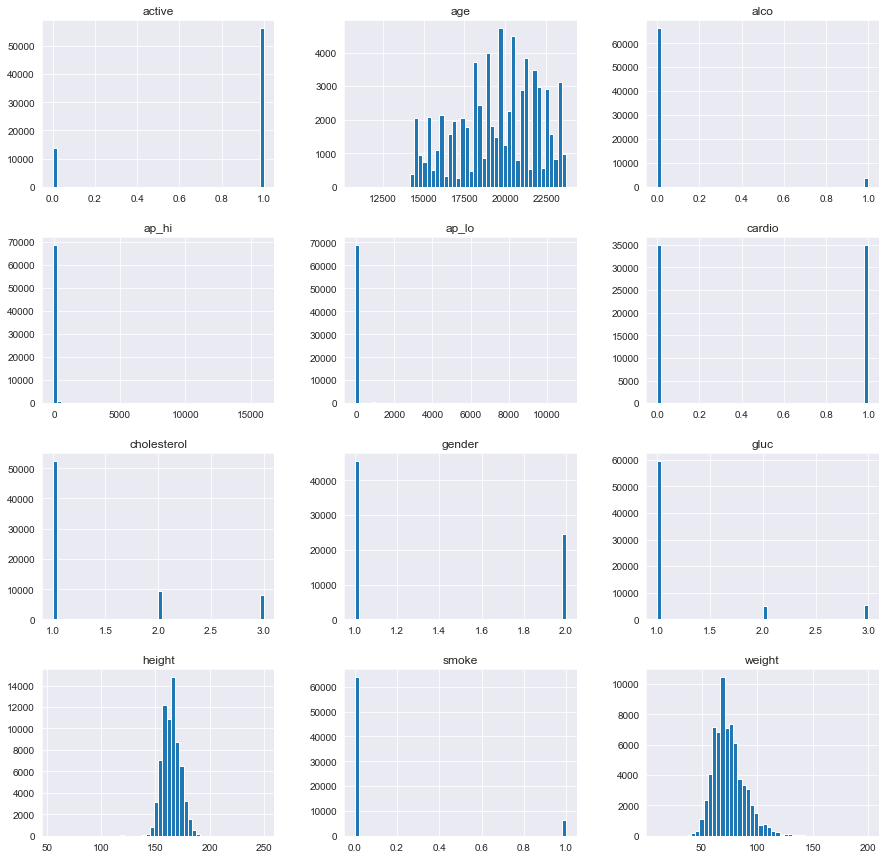

In [113]:
#Построим частотные графики для всех атрибутов, кроме id
data.iloc[:,1:].hist(figsize=(15,15), bins=50)
plt.show()

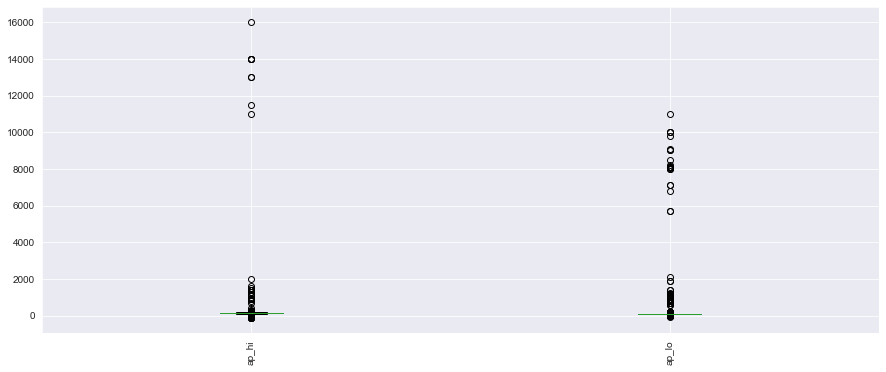

In [116]:
# По графику можно понять, что в атрибтах ap_hi, ap_lo есть выбросы (неадекватно завышенные значения)
# В графике boxplot наглядно видны выбросы (давление не может измерятся в тысячах и не может быть отрицательным)
boxplot = data[['ap_hi','ap_lo']].boxplot(figsize = (15,6), rot = 90)

In [117]:
# почистим данные
# повышенное артериальное давление четвертой степени 210/120 и крайне низкое артериальное давление 50/35
new_data = data[(data['ap_hi'] <= 210) & (data['ap_hi'] >= 50) & (data['ap_lo'] <= 120) & (data['ap_lo'] >= 35)]
# рост от 140 до 200 см
new_data = new_data[(new_data['height'] <= 210) & (new_data['height'] >= 140)]
# сколько очистили выбросов на данном этапе 
print(f'Общее количество очищенных данных - {len(data) - len(new_data)}')

Общее количество очищенных данных - 1496


In [118]:
# # Выделим столбцы для предсказания
# new_data = new_data.iloc[:,1:12]
# new_data.head()

x, y = new_data.drop(['id', 'cardio'], axis = 1), new_data.cardio

In [119]:
# нормализуем параметры
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
np_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(np_scaled)
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.588076,1.0,0.417910,0.269841,0.333333,0.500,0.0,0.0,0.0,0.0,1.0
1,0.730159,0.0,0.238806,0.391534,0.533333,0.625,1.0,0.0,0.0,0.0,1.0
2,0.624003,0.0,0.373134,0.280423,0.466667,0.375,1.0,0.0,0.0,0.0,0.0
3,0.528455,1.0,0.432836,0.375661,0.600000,0.750,0.0,0.0,0.0,0.0,1.0
4,0.516918,0.0,0.238806,0.238095,0.266667,0.250,0.0,0.0,0.0,0.0,0.0


In [120]:
# присвоим изначальное наименование столбцов
headers = list(x.columns.values)
headers
df_norm.columns = headers
df_norm.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0.588076,1.0,0.417910,0.269841,0.333333,0.500,0.0,0.0,0.0,0.0,1.0
1,0.730159,0.0,0.238806,0.391534,0.533333,0.625,1.0,0.0,0.0,0.0,1.0
2,0.624003,0.0,0.373134,0.280423,0.466667,0.375,1.0,0.0,0.0,0.0,0.0
3,0.528455,1.0,0.432836,0.375661,0.600000,0.750,0.0,0.0,0.0,0.0,1.0
4,0.516918,0.0,0.238806,0.238095,0.266667,0.250,0.0,0.0,0.0,0.0,0.0


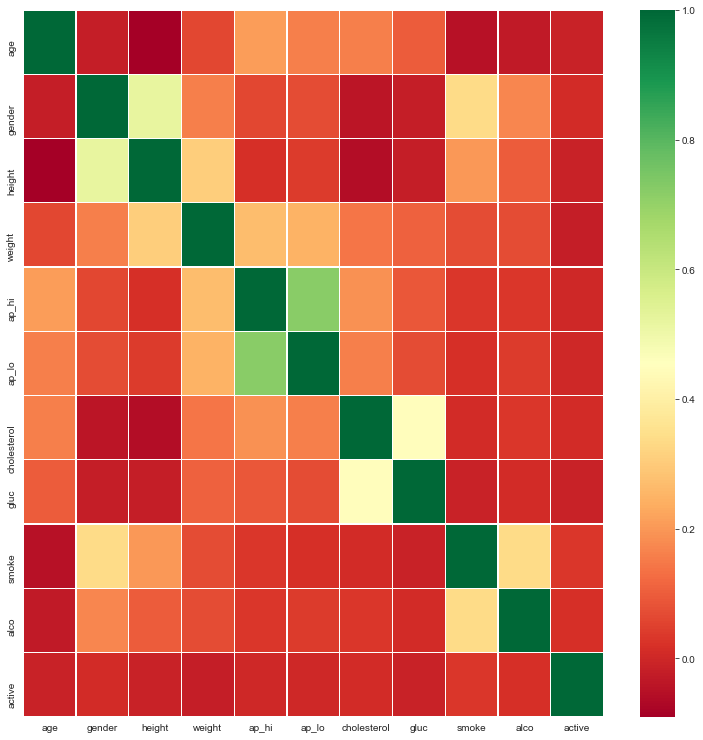

In [121]:
# построим матрицу корреляций
f, ax = plt.subplots(figsize = (13, 13))
corr = np.round_(df_norm.corr(), decimals = 2)
sns.heatmap(corr,annot = False,cmap = 'RdYlGn',linewidths = 0.2)
plt.show()
# на матрице видно, что сильно коррелируемых значений нет

In [122]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_norm, y, test_size = 0.2, random_state = 42)

In [123]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model = RandomForestClassifier(n_estimators = 100, n_jobs = 4)

# обучаем модель
%time model.fit(x_train,y_train)

Wall time: 5.09 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

No handles with labels found to put in legend.


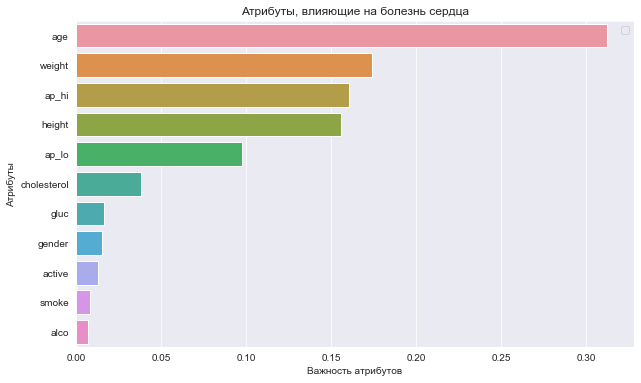

In [124]:
feature_imp = pd.Series(model.feature_importances_,index = headers).sort_values(ascending = False)

f, ax = plt.subplots(figsize = (10, 6))
sns.barplot(x = feature_imp, y = feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Атрибуты, влияющие на болезнь сердца")
plt.legend()
plt.show()
list(zip(headers, model.feature_importances_))
plt.show()
# Наиболее важный атрибут это возраст

In [125]:
from sklearn.metrics import classification_report

model_pred = model.predict(x_test)
print(classification_report(y_test, model_pred))
# Модель "рандомных деревьев" дала точность предсказания 71%.

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      6898
           1       0.72      0.68      0.70      6803

    accuracy                           0.71     13701
   macro avg       0.71      0.71      0.71     13701
weighted avg       0.71      0.71      0.71     13701



In [127]:
# Проверим с помощью ttest гипотезу , что старые люди чаще заболевают чаще , чем молодые

import researchpy as rp
# Showing descriptive statistics from researchpy.summary_cont()
rp.summary_cont(new_data.groupby('cardio')['age'])

,N,Mean,SD,SE,95% Conf.,Interval
cardio,,,,,,
0,34638,18879.350251,2472.211435,13.283399,18853.314414,18905.386088
1,33866,20061.479655,2316.146100,12.585892,20036.810943,20086.148368


In [133]:
descriptives, results = rp.ttest(new_data['cardio'], data['age'])
results

,Independent t-test,results
0,Difference (cardio - age) =,-19468.3714
1,Degrees of freedom =,138502.0000
2,t =,-2065.2570
3,Two side test p value =,0.0000
4,Difference < 0 p value =,0.0000
5,Difference > 0 p value =,1.0000
6,Cohen's d =,-11.0994
7,Hedge's g =,-11.0993
8,Glass's delta =,-38938.9314
9,r =,0.9841


In [ ]:
# p value = 0, это значит, что выборки здоровых и больных людей по возрасту статистически различаются, 
# при этом количество здоровых и больных людей приблизительно одинаково.

In [134]:
age = new_data.groupby('cardio')['age'].mean()
healthy = int(age.loc[0])
ill = int(age.loc[1])
print(f'Средний возраст здоровых людей - {round(healthy / 365)}')
print(f'Средний возраст больных людей - {round(ill / 365)}')
# Средний возраст здоровых людей 52 года, а больных 55, т.е. здоровые люди более молодные, что логично

Средний возраст здоровых людей - 52
Средний возраст больных людей - 55


In [135]:
# # Средний вес человека в мире — 62 кг
weight_max = new_data[new_data['weight'] >= 62].cardio
weight_min = new_data[new_data['weight'] <= 62].cardio

In [136]:
descriptives, results = rp.ttest(weight_max, weight_min)
print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  56850.0  0.520317  0.499591  0.002095   0.516210  0.524423
1    cardio  13477.0  0.373896  0.483855  0.004168   0.365727  0.382066
2  combined  70327.0  0.492258  0.499944  0.001885   0.488563  0.495953
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =       0.1464
1            Degrees of freedom =   70325.0000
2                             t =      30.7739
3         Two side test p value =       0.0000
4        Difference < 0 p value =       1.0000
5        Difference > 0 p value =       0.0000
6                     Cohen's d =       0.2948
7                     Hedge's g =       0.2948
8                 Glass's delta =       0.2931
9                             r =       0.1153


In [ ]:
# p value = 0, это значит, что выборки здоровых и больных людей по весу имеют статистические различия, 
# при этом количество здоровых и больных людей приблизительно одинаково.